In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import pickle as pkl
import joblib
from sklearn.metrics import silhouette_score
from math import radians, cos, sin, asin, sqrt 

In [45]:
class TourRecommandationSystem():
    def __init__(self, f_name,sample):
        self.dataset = pd.read_csv(f_name)[:sample]
        self.pre_data = {}
        self.stdScl = StandardScaler()
        self.distortion_map = {}
        self.interia_map = {}
        self.silho_map = {}
        self.no_of_clst = None
        self.x_train = None
        
    def preprocess_date(self):
        utcTimeStamp = pd.to_datetime(self.dataset['utcTimestamp'])
        self.dataset['date'] = utcTimeStamp.dt.date
        self.dataset['year'] = utcTimeStamp.dt.year
        self.dataset['month'] = utcTimeStamp.dt.month
        self.dataset = self.dataset.drop(['utcTimestamp'],axis=1)
        
    def create_model_data(self):
        self.pre_data['venueId'] = self.dataset['venueId']
        self.pre_data['latitude'] = self.dataset['latitude']
        self.pre_data['longitude'] = self.dataset['longitude']
        self.pre_data = pd.DataFrame(self.pre_data)
        
    def split_data(self,train_size=80):
        data = self.pre_data[['latitude','longitude']]
        self.x_train = data.values
        
    def pre_process_data(self):
        self.x_train = self.stdScl.fit_transform(self.x_train)
        
    def draw_line_graph(self,labels,cls_cnt,gph_tilte,x_label,y_label):
        plt.plot(labels,cls_cnt)
        plt.title(gph_tilte)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.plot()
    
    def draw_bar_graph(self,labels,cls_cnt,gph_tilte,x_label,y_label):
        plt.bar(labels,cls_cnt)
        plt.title(gph_tilte)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.plot()
        
    def plot_elbow_graph(self,l=10,r=20):
        self.no_of_clst = np.arange(l,r)
        distortions=[]
        for x in self.no_of_clst:
            kmean = KMeans(n_clusters=x)
            kmean.fit(self.x_train)
            #calculate distortion 
            distortions.append(sum(np.min(cdist(self.x_train, kmean.cluster_centers_, 
                      'euclidean'),axis=1)) /self.x_train.shape[0]) 
            
            self.distortion_map[x] = sum(np.min(cdist(self.x_train, kmean.cluster_centers_, 
                      'euclidean'),axis=1)) / self.x_train.shape[0]
            self.interia_map[x] = kmean.inertia_
        
        self.draw_line_graph(self.no_of_clst,distortions,"Elbow Methods","No of clusters","Cost functions")
        
    def get_silhouette_score(self,l=10,r=20):
        self.no_of_clst = np.arange(l,r)
        score = []
        for x in self.no_of_clst: 
            kmean = KMeans(n_clusters = x) 
            cluster_labels = kmean.fit_predict(self.x_train) 
            silhouette_avg = silhouette_score(self.x_train, cluster_labels)
            self.silho_map[x]= silhouette_avg
            score.append(silhouette_avg)
        
        self.draw_bar_graph(self.no_of_clst,score,"Silhouette Score","Cluster","Score")
    
    def get_max_score(self,l=10,r=20):
        self.no_of_clst = np.arange(l,r)
        score = []
        mx = 0
        clst= 0
        for x in self.no_of_clst: 
            kmean = KMeans(n_clusters = x) 
            cluster_labels = kmean.fit_predict(self.x_train) 
            silhouette_avg = silhouette_score(self.x_train, cluster_labels)
            
            if(mx < silhouette_avg):
                mx = silhouette_avg
                clst = x
                
        return clst
            
    def train_model(self,n_clust):
        print("Trained clusters: "+str(n_clust))
        kmean = KMeans(n_clusters=n_clust)
        kmean.fit(self.x_train)
        joblib.dump(kmean, "final_model.sav")
    
    def assign_score(self):
        kmean = joblib.load("final_model.sav") 
        res = kmean.predict(self.x_train)
        self.dataset['cluster']=res
    
    def cal_dist(self,x1,y1,x2,y2):
        lat1, lng1 =radians(x1), radians(y1) 
        lat2, lng2 = radians(y2), radians(x2)
        dlon = lng2 - lng1  
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

        c = 2 * asin(sqrt(a))  
        r = 6371 
        return(c * r) 
    
    def recommand_place(self,lat,lng,top_place=10):
        kmean = joblib.load("final_model.sav") 
        res = kmean.predict([[lat,lng]])
        data = self.dataset[self.dataset['cluster']==res[0]]
        rcd_plc = {}
        place_name = data['venueCategory'].values
        place_lat = data['latitude'].values
        place_lng = data['longitude'].values
        
        for p_name,p_lat,p_lng in zip(place_name,place_lat,place_lng):
            rcd_plc[self.cal_dist(lat,lng,p_lat,p_lng)] = {'place':p_name,'lat':p_lat,'lng':p_lng}
            
            
        rcd_plc = sorted(rcd_plc.items(),key=lambda kv:kv[0])
        return rcd_plc[:top_place]
    
    def print_data(self,n=5):
        print(self.dataset.head(n))
    
    def print_interia(self):
        for k,v in self.interia_map.items():
            print("cluster "+str(k)+": "+str(v))
        
    def print_silhouette_score(self):
        for k,v in self.silho_map.items():
            print("cluster "+str(k)+": "+str(v))
            
    def save_dataset(self):
        self.dataset.to_csv('new_dataset.csv',index=False)

In [46]:
if __name__ == "__main__":
    trs = TourRecommandationSystem("dataset_TSMC2014_NYC.csv",sample=1000)
#     trs.preprocess_date()
    trs.create_model_data()
    trs.split_data()
    

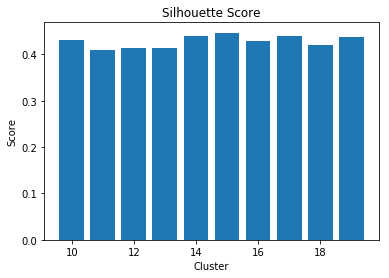

In [47]:
trs.get_silhouette_score()

In [48]:
trs.print_silhouette_score()

cluster 10: 0.430377859431583
cluster 11: 0.4094862573196994
cluster 12: 0.41430872846036076
cluster 13: 0.4133108925402875
cluster 14: 0.4403650593332693
cluster 15: 0.44686376640380654
cluster 16: 0.42984257349975563
cluster 17: 0.4402725595975233
cluster 18: 0.4200707063547269
cluster 19: 0.43782157473201927


In [49]:
trs.train_model(trs.get_max_score(l=10,r=20))
trs.assign_score()

Trained clusters: 16


# Test my model against given data points

In [50]:

top_place=10
predLat= 40.719810
predLng= -74.002581
data_points = trs.recommand_place(lat=predLat,lng=predLng,top_place =top_place)
print("Top "+str(top_place)+" place reommended near you on the basis of data:")
for data in data_points:
    print(data[1]['place'])


Top 10 place reommended near you on the basis of data:
Gas Station / Garage
Bar
Subway
Music Venue
Dessert Shop
Diner
Sushi Restaurant
Restaurant
Ramen /  Noodle House
Ferry


# visulization of data points on the map

In [51]:
from ipyleaflet import Map, Marker, CircleMarker

center = (predLat,predLng)
#here red circle represent user location on the map
m = Map(center=center, zoom=20)

circle_marker = CircleMarker()
circle_marker.location = center
circle_marker.radius = 10
circle_marker.color = "red"
circle_marker.fill_color = "red"
m.add_layer(circle_marker);

for data in data_points:
    lat = data[1]['lat']
    lng = data[1]['lng']
    name =data[1]['place']
    marker = Marker(location=(lat,lng), draggable=False,title = name,rise_on_hover=True)
    m.add_layer(marker);
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# Read Dataset

In [52]:
import pandas as pd


In [53]:
data = pd.read_csv("dataset_TSMC2014_NYC.csv")
data.head(5)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012


In [54]:
data = data[["venueId",'latitude','longitude']]
data.head(5)

,venueId,latitude,longitude
0,49bbd6c0f964a520f4531fe3,40.719810,-74.002581
1,4a43c0aef964a520c6a61fe3,40.606800,-74.044170
2,4c5cc7b485a1e21e00d35711,40.716162,-73.883070
3,4bc7086715a7ef3bef9878da,40.745164,-73.982519
4,4cf2c5321d18a143951b5cec,40.740104,-73.989658


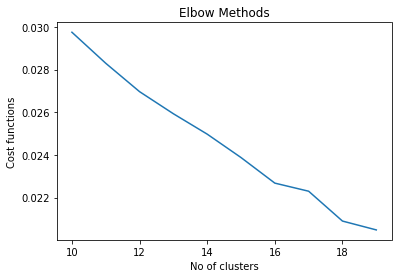

In [55]:
trs.plot_elbow_graph()

In [56]:
trs.pre_process_data()
print("PreProcessed Data:\n")
print(trs.x_train)

PreProcessed Data:

[[-0.50353894 -0.20199079]
 [-2.10556229 -0.67356619]
 [-0.55526233  1.15314473]
 ...
 [-1.56277238  2.27057025]
 [-0.27963703  0.14518301]
 [-1.57681058 -1.30437796]]


# Save New Dataset

In [57]:
trs.save_dataset()

In [58]:
data = pd.read_csv("new_dataset.csv")
data.head(5)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,cluster
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012,8
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012,6
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012,12
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012,3
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012,3
